## Installing Packages



In [2]:
# !pip3 install rdkit
# !conda install -c conda-forge umap-learn
# !pip install bokeh

## Import dependencies

In [1]:
import rdkit
from IPython.core.display import display, HTML

from rdkit.Chem.Draw import IPythonConsole # This will let you draw structures in this Colab notebook.
from rdkit.Chem import Draw
from rdkit import Chem, DataStructs
from rdkit.Chem import (AllChem, Crippen, Descriptors, Lipinski, MolSurf,
                        rdMolDescriptors)
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import umap
from typing import List

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from numpy import random

import warnings
warnings.filterwarnings("ignore")


C:\Users\hongt\anaconda3\envs\molecule\lib\site-packages\llvmlite\llvmpy\__init__.py:4: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  "The module `llvmlite.llvmpy` is deprecated and will be removed in the "
C:\Users\hongt\anaconda3\envs\molecule\lib\site-packages\llvmlite\llvmpy\core.py:9: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  "The module `llvmlite.llvmpy.core` is deprecated and will be removed in "
C:\Users\hongt\anaconda3\envs\molecule\lib\site-packages\llvmlite\llvmpy\passes.py:18: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  "The module `llvmlite.llvmpy.passes` is deprecated and will be removed in "


## Create the datasets


In [2]:
# solubility prediction task (https://pubs.acs.org/doi/10.1021/ci034243x)
dataset = pd.read_csv("data/delaney-processed.csv", index_col="Compound ID")

In [4]:
print(f"Rows: {dataset.shape[0]}, Columns: {dataset.shape[1]}")
print("")

for i, col in enumerate(dataset.columns):
    print(i,col)
print("")
print(dataset.index[0:5])

compound_id = dataset.index

Rows: 1121, Columns: 9

0 ESOL predicted log solubility in mols per litre
1 Minimum Degree
2 Molecular Weight
3 Number of H-Bond Donors
4 Number of Rings
5 Number of Rotatable Bonds
6 Polar Surface Area
7 measured log solubility in mols per litre
8 smiles

Index(['Amigdalin', 'Fenfuram', 'citral', 'Picene', 'Thiophene'], dtype='object', name='Compound ID')


In [5]:
dataset[["smiles", "measured log solubility in mols per litre"]].head(5)

,smiles,measured log solubility in mols per litre
Compound ID,,
Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30
citral,CC(C)=CCCC(C)=CC(=O),-2.06
Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
Thiophene,c1ccsc1,-1.33


In [6]:
smiles_strings = dataset["smiles"].values

# These are your ground-truth outputs/labels
labels = dataset["measured log solubility in mols per litre"].values


In [7]:
#converts LogS into positive or negative catergories. 
cat_labels = np.where(labels>0,1,0)

In [8]:
dataset["measured log solubility in mols per litre"].describe()

count    1121.000000
mean       -3.028085
std         2.080242
min       -11.600000
25%        -4.300000
50%        -2.840000
75%        -1.600000
max         1.580000
Name: measured log solubility in mols per litre, dtype: float64

In [9]:
logS = dataset["measured log solubility in mols per litre"].values

Along with those inputs and labels, our dataset provides a few calculated properties about the molecules that may be helpful in exploratory data analysis later. 

In [10]:
calculated_properties = dataset[
    [
      "Molecular Weight",
      "Number of H-Bond Donors",
      "Number of Rings",
      "Number of Rotatable Bonds",
      "Polar Surface Area"
    ]
]
calculated_properties.head()

,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
Compound ID,,,,,
Amigdalin,457.432,7,3,7,202.32
Fenfuram,201.225,1,2,2,42.24
citral,152.237,0,0,4,17.07
Picene,278.354,0,5,0,0.00
Thiophene,84.143,0,1,0,0.00


# Featurization

In [11]:
def compute_fingerprint(mol: rdkit.Chem.Mol) -> np.ndarray:
    """ Given an rdkit mol, compute a fingerprint which is a 2048-bit vector to represent a molecular structure.
    """
    arr = []
    try:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    except:
        return []
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [12]:
rdkit_mols = [Chem.MolFromSmiles(s) for s in smiles_strings]
fingerprints = np.stack([compute_fingerprint(m) for m in rdkit_mols]) # These are your features
print(fingerprints.shape)
print(labels.shape)

(1121, 2048)
(1121,)


# Explore Data

In [13]:
import plotly.express as px # For histograms
import plotly.graph_objects as go # For pie charts

In [14]:
def draw_hist(df, col, nbins, title="Distribution"):
    '''
        Draws a Plotly histogram from the given data.
    '''
    fig = px.histogram(df, x=col, nbins=nbins)
    fig.update_layout(title_text=title)
    fig.show()

In [15]:
print(calculated_properties.columns)

Index(['Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings',
       'Number of Rotatable Bonds', 'Polar Surface Area'],
      dtype='object')


In [16]:
print(calculated_properties["Number of H-Bond Donors"].unique())
print(calculated_properties['Number of Rings'].unique())
print(calculated_properties['Number of Rotatable Bonds'].unique())

[ 7  1  0  2  4  3  6 11  5  8]
[3 2 0 5 1 4 6 7]
[ 7  2  4  0  1  3 11  8  5  6  9 10 15 14 12 13]


In [18]:
draw_hist(calculated_properties, "Number of H-Bond Donors", 20, "H-Bond Donors distribution - full dataset")
draw_hist(calculated_properties, "Number of Rings", 20, "Number of Rings distribution - full dataset")
draw_hist(calculated_properties, "Number of Rotatable Bonds", 20, "Rotatable Bonds distribution - full dataset")

In [19]:
print(calculated_properties[['Molecular Weight','Polar Surface Area']].describe()) 
print(calculated_properties[['Molecular Weight','Polar Surface Area']].info())

       Molecular Weight  Polar Surface Area
count       1121.000000         1121.000000
mean         202.314200           34.634514
std           99.723782           34.814372
min           16.043000            0.000000
25%          121.139000            0.000000
50%          182.156000           26.300000
75%          269.127000           55.400000
max          588.562000          268.680000
<class 'pandas.core.frame.DataFrame'>
Index: 1121 entries, Amigdalin to Stirofos
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecular Weight    1121 non-null   float64
 1   Polar Surface Area  1121 non-null   float64
dtypes: float64(2)
memory usage: 26.3+ KB
None


In [20]:
def categorize_MW(x: float):
    if x < 100:
        return 1
    elif 100 <= x < 200:
        return 2
    elif 200 <= x < 300:
        return 3
    elif 300<=x < 400:
        return 4
    if 400<= x < 500:
        return 5
    if 500<= x < 600:
        return 6

def categorize_PSA(x: float):
    if x < 17:
        return 1
    elif 17 <= x < 34:
        return 2
    elif 34 <= x < 51:
        return 3
    elif 51 < x < 68:
        return 4
    else:
        return 5    

In [21]:
properties_df = calculated_properties[['Molecular Weight','Polar Surface Area']].copy(deep=True)
properties_df['Molecular Weight'] = properties_df['Molecular Weight'].apply(lambda x: categorize_MW(x))
properties_df['Polar Surface Area'] = properties_df['Polar Surface Area'].apply(lambda x: categorize_PSA(x))

draw_hist(properties_df, "Molecular Weight",10, "molecular_weight distribution - full dataset")
draw_hist(properties_df, "Polar Surface Area", 10, "Polar Surface Area distribution - full dataset")

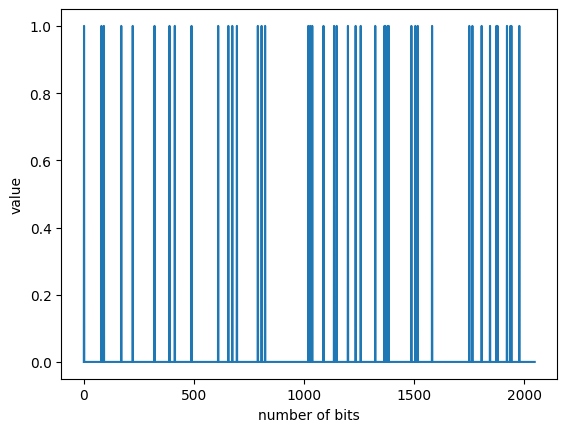

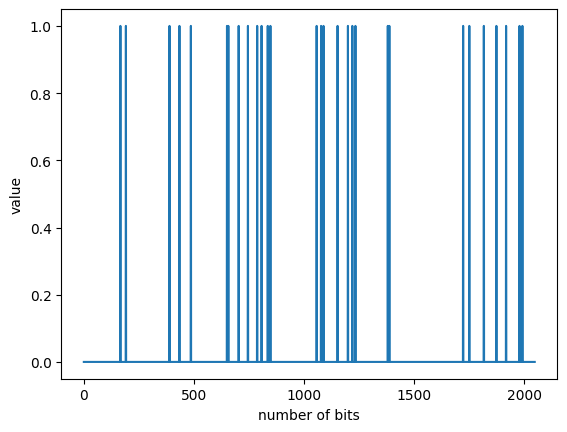

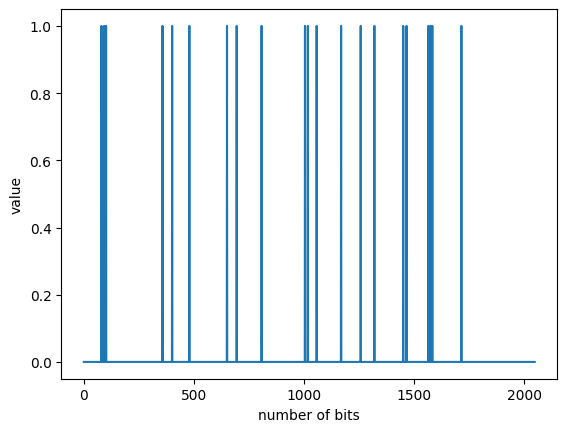

In [22]:
def visualize_fingerprint(fp_list: List[np.array], numberOfBits: int = 2049, number: int = 5):
    x = [i for i in range(1,numberOfBits)] 

    for i in range(number):
        plt.plot(x, fp_list[i])
        plt.ylabel("value")
        plt.xlabel("number of bits")
        plt.show()

visualize_fingerprint(fingerprints, 2049, 3)

# Baseline model- Linear Regression

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [24]:
# Your code goes here
reg = LinearRegression().fit(fingerprints, labels)

score= reg.score(fingerprints,labels)
print(f'regression score: {score}')

coef = reg.coef_


regression score: 0.9850131152399826


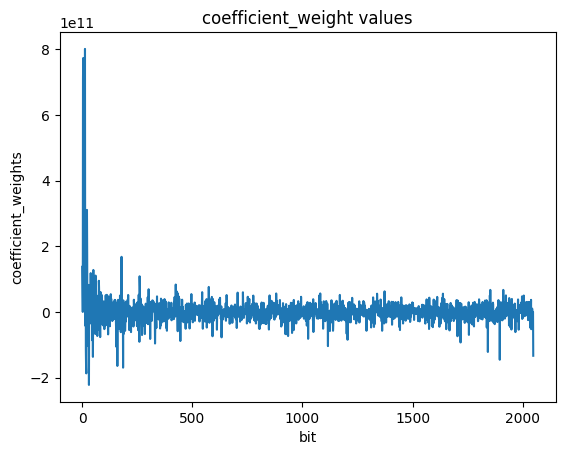

In [25]:
numberofbits = [i for i in range(1,2049)]

plt.plot(numberofbits,coef)
plt.title("coefficient_weight values")
plt.ylabel("coefficient_weights")
plt.xlabel("bit")
plt.show()

You should now have a trained linear regression model. Since your input had 2048 features, it should have 2048 coefficient weights. 

**Task:** Do some visual exploratory analysis on these weights. What does the distribution of coefficient weights look like? Does this model seem like it would generalize well? If so, why? If not, what are some reasons this may be the case? Justify your answer with data and visualizations. 

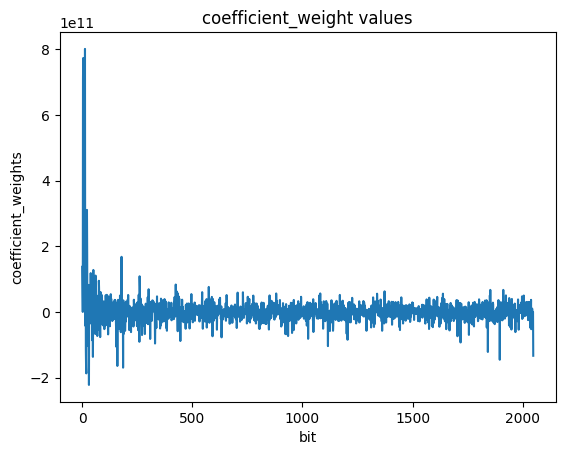

In [26]:
# Your code/analysis here. 
numberofbits = [i for i in range(1,2049)]

plt.plot(numberofbits,coef)
plt.title("coefficient_weight values")
plt.ylabel("coefficient_weights")
plt.xlabel("bit")
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(fingerprints,labels,test_size=0.2, random_state=42)

In [28]:
reg = LinearRegression().fit(X_train,y_train)
print(reg.score(X_train,y_train))

0.9831683241551195


In [29]:
y_pred = reg.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print(mse)

1.6888343510258536e+25


The distribution of coefficient is skewed on the left within the first five hundreds bits. From my experience, regresion score is 98% for this model is a sign of overfitting. Indeed, Mean Squared Error of prediction and y_test was large, which proves the model is too simple for this complex dataset. Therefore, I will try apply cross validation or we can select important features only to see if I could improve the performance of the models. 

I don't think linear regression is a right model to predict the solubility of of a molecule based on the molecular fragments. Because those molecular fragments which are embedded in the ECFPs may not linearly corelated with the solubility of a corresponding molecule. In addition, each feature of a fingerprint instance has a binary value which is not suitable for linear regression model to learn as it requires multivariate values for each features. Thus, the calculated_properties are more appropriate to predict molecular solubility than this fingerprint dataset. 

My suggestion is to use CNN-RNN or Graph Convolutional NN (Message Passing NN) to extract molecular features and classify chemical activity. 

In [30]:
from sklearn.model_selection import cross_val_score

In [31]:
reg = LinearRegression()
scores = cross_val_score(reg, X_train,y_train, scoring="r2", cv=5)
print(scores)
print(f"average regression score after 10-fold cross validation : {scores.mean()}")

[-4.76897941e+24 -6.91126337e+24 -1.46930564e+24 -2.99633497e+24
 -3.27817385e+25]
average regression score after 10-fold cross validation : -9.78552437088575e+24


with cross validation, the model still could not learn this dataset. 

In [32]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(fingerprints[:,:100], labels, test_size=0.2, random_state=42)

reg = LinearRegression()
scores_first_100bits = cross_val_score(reg, new_X_train, new_y_train, scoring="r2", cv=5)
print(scores_first_100bits)
print(f"average regression score after 5-fold cross validation : {scores_first_100bits.mean()}")

[-7.88313959e+20 -3.24893119e+21 -4.13302181e+22 -3.17622380e-02
 -8.32622405e+10]
average regression score after 5-fold cross validation : -9.073492658136624e+21


regression model is still overfitting. 

**Task:** What statistical assumption(s) of least squares regression does this dataset break? Justify your answer with data and/or visualizations.

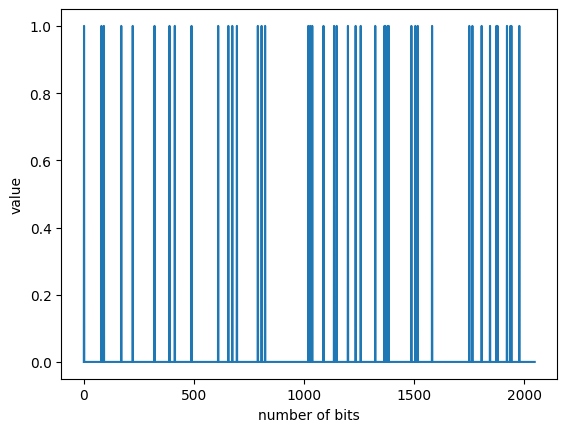

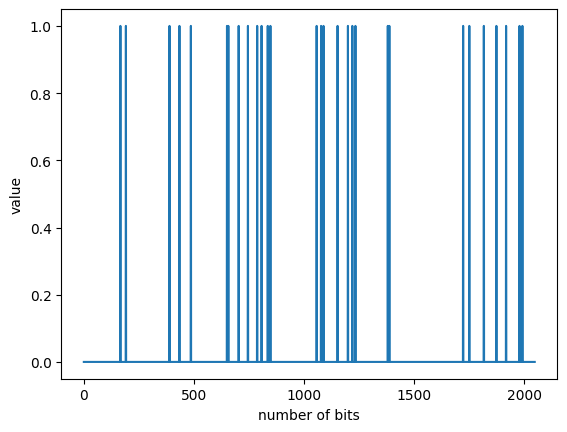

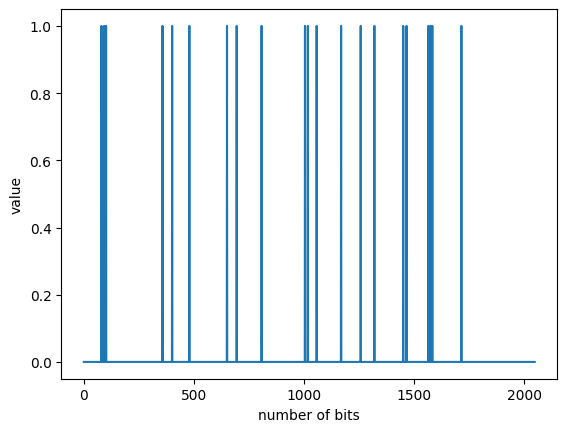

In [33]:
visualize_fingerprint(fingerprints, 2049, 3)

- Least Squares regression assumes that each feature has linear relationship with the labels. However based on the outcomes of the examples_of_bit(), those fragments just show the similar patterns in the molecules but do not indicate the solubility of the corresponding molecules.
- each feature should be multivariate not binary. I have showed the above figures.  

# Visualize molecular structures with RDkit

In [34]:
# Recall that our inputs were smiles strings, which we featurized as rdkit Mol objects
print(f"Number of SMILES strings: {smiles_strings.shape[0]}")
print(f"Number of RDKit Mols: {len(rdkit_mols)}")
print(f"Example SMILES string: {smiles_strings[0]}")

Number of SMILES strings: 1121
Number of RDKit Mols: 1121
Example SMILES string: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


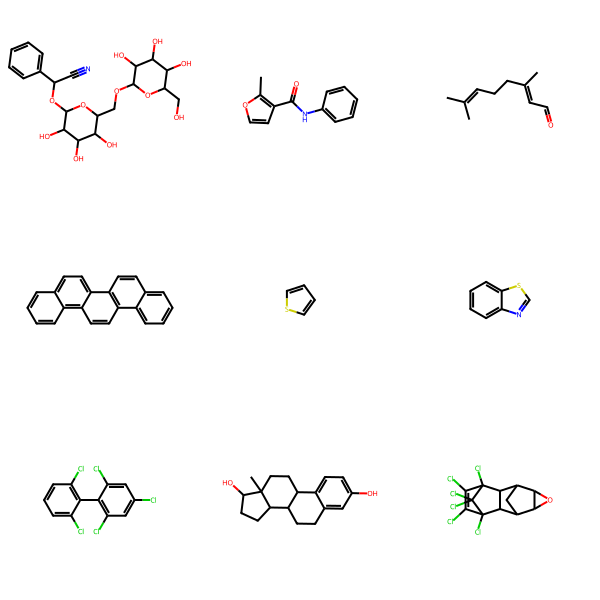

In [36]:
rdkit.Chem.Draw.MolsToGridImage(rdkit_mols[0:9], useSVG=True)

K-Means is a common unsupervised method for clustering. The first idea came to me is to compute the similarity of a molecule with others via eucledian distance. With that said, molecules with similar structure should be close together. Thus, it could be better at predicting solubility of each cluster.

In [37]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(fingerprints)
  
    distortions.append(sum(np.min(cdist(fingerprints, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / fingerprints.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(fingerprints, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / fingerprints.shape[0]
    mapping2[k] = kmeanModel.inertia_

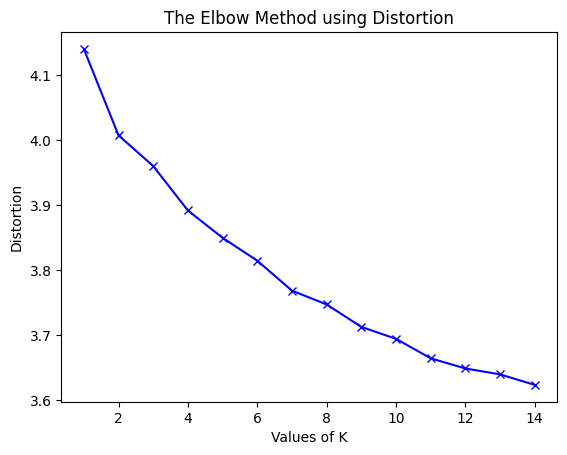

In [38]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

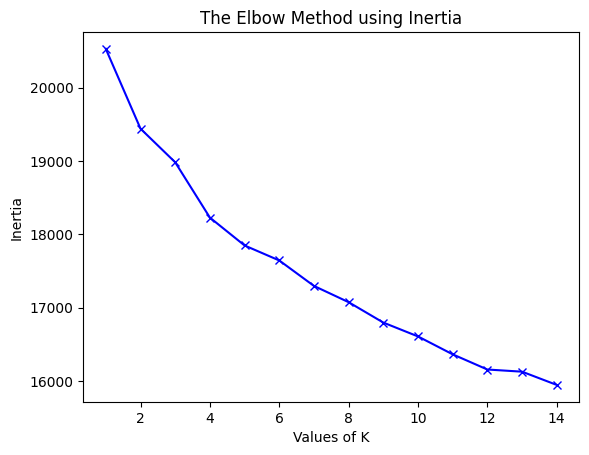

In [39]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In the above, I have utilized elbow method to guess the optimal K for k-nearest neigbors algorithm. I found k=8, which seems to be good for clustering those molecules. however, since we know there are two major group in this dataset. I will chose k=2 for the K-means algorithm.

In [40]:
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
mol_clusters = kmeans.fit_predict(fingerprints)

In [41]:
from collections import Counter
print(Counter(mol_clusters))

Counter({0: 628, 1: 493})


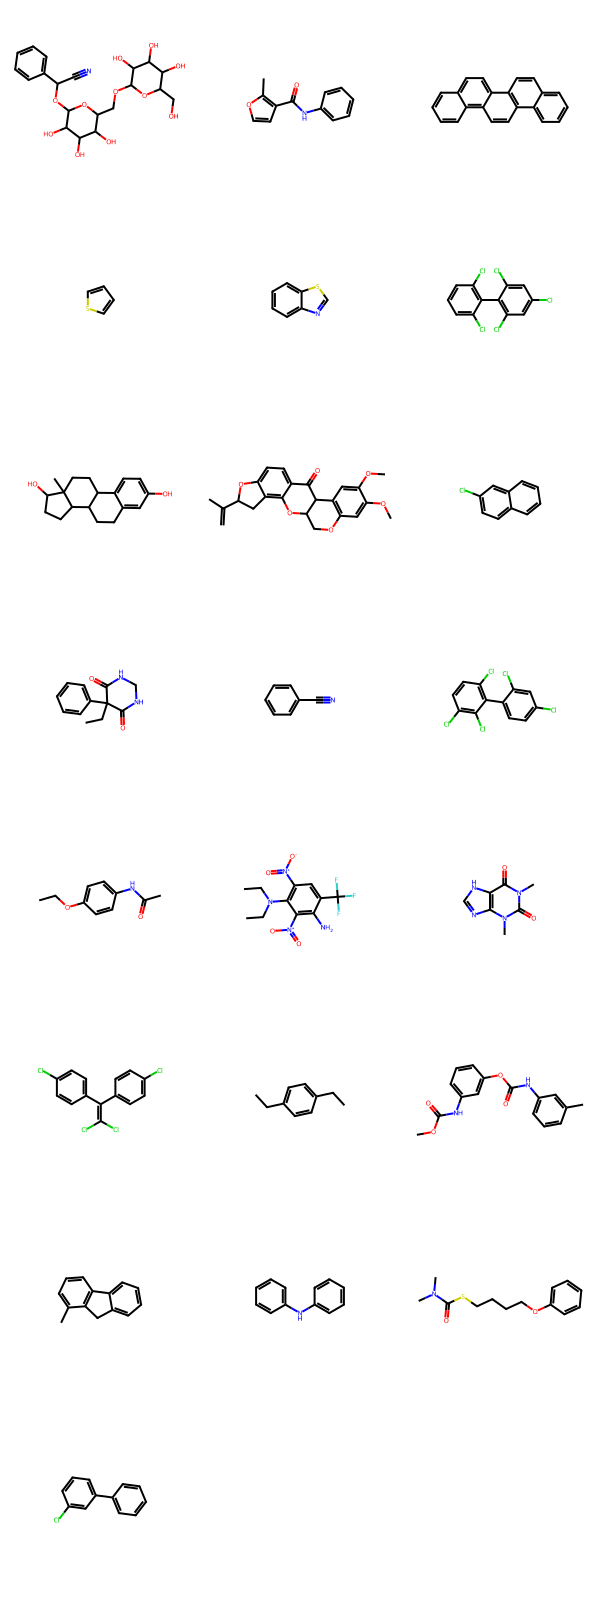

In [42]:
def get_cluster(grp_num: int) -> List[object]:
    '''
    this function selects rdkit_mols which belong in a specific cluster grp_num 
    '''
    cluster = []
    for i in range(len(mol_clusters)):
        if mol_clusters[i] == grp_num:
            cluster.append(rdkit_mols[i])
    return cluster

cluster_6 = get_cluster(0)

rdkit.Chem.Draw.MolsToGridImage(cluster_6[0:22], useSVG=True)


Some molecules has bulky structures, which has multiple rings while others alkanes, or alkens. Thus, it implies that K-means does not comprehend the structure-solubility relationship. 

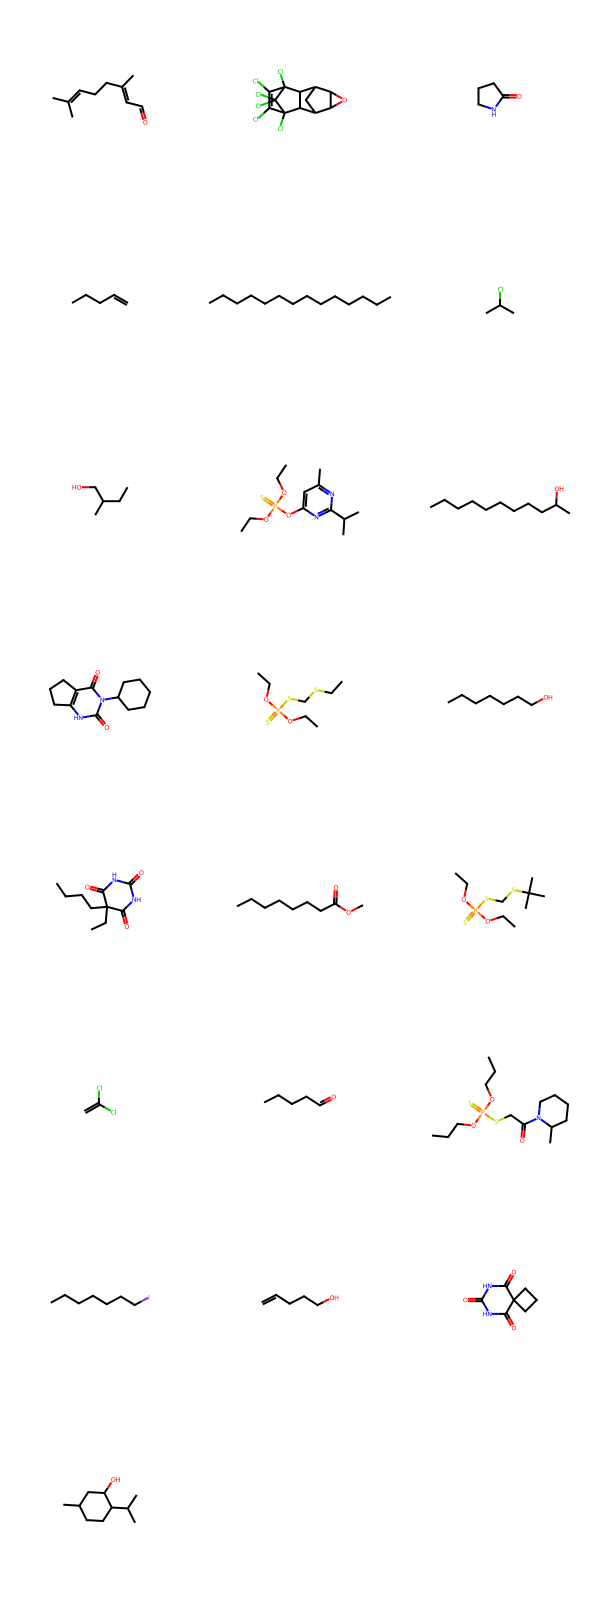

In [43]:
cluster_1 = get_cluster(1)

rdkit.Chem.Draw.MolsToGridImage(cluster_1[0:22], useSVG=True)

In contrast, the molecules in the clusters 1 have more rings in their structure, which means they are likely to be insoluble molecules in water.

From my understanding, Eucledian distance is not a good metric to measure high dimensional data due to the curse of dimensionality. In addition, if two bit vectors as those bit vectors get larger, the distance would also get larger.   

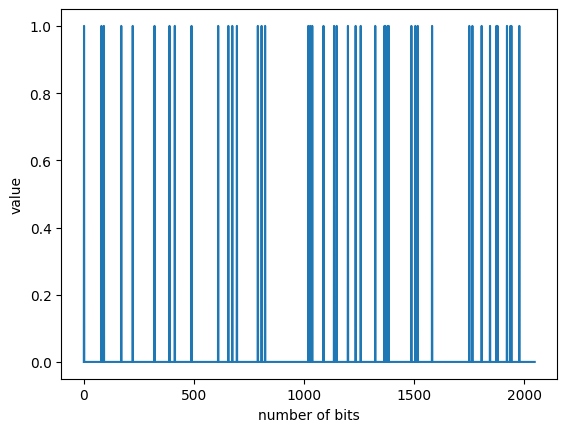

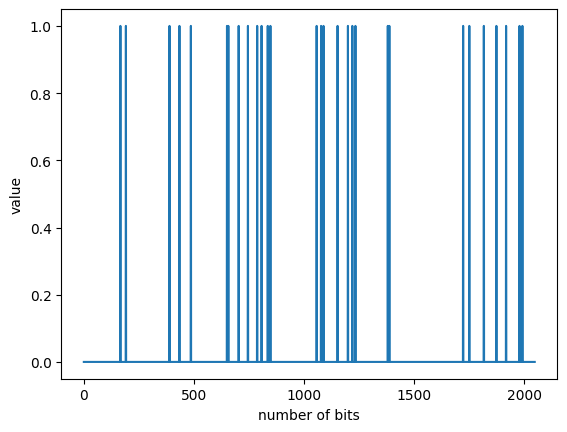

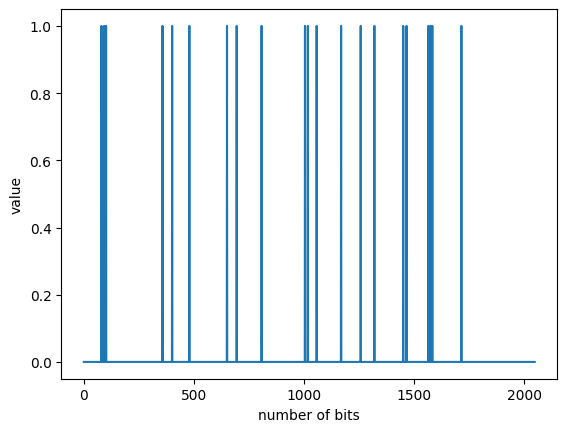

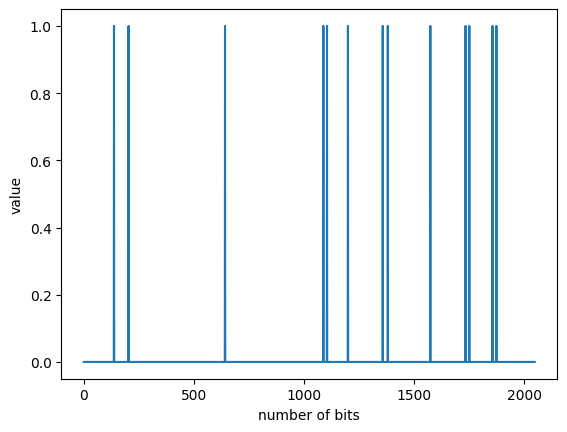

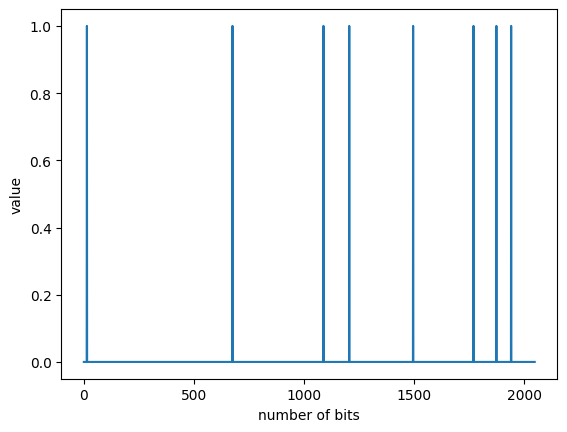

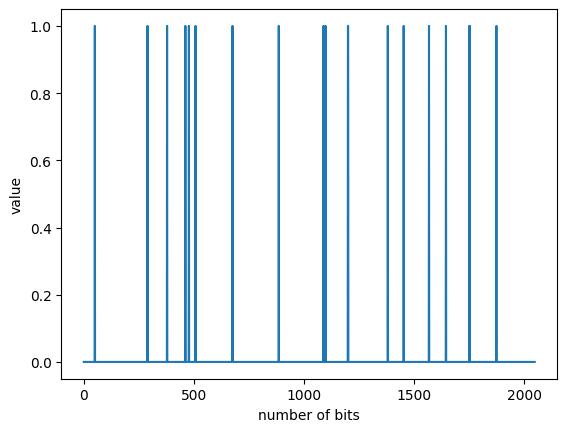

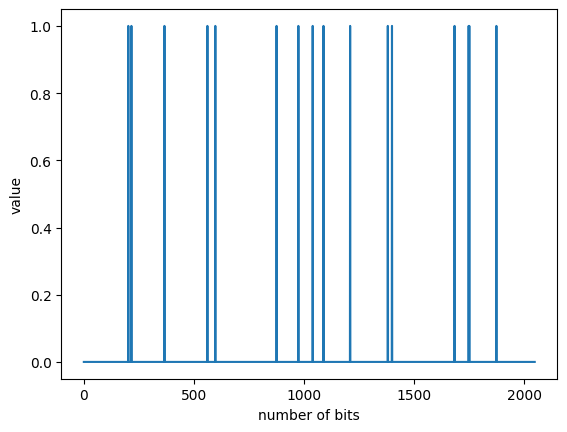

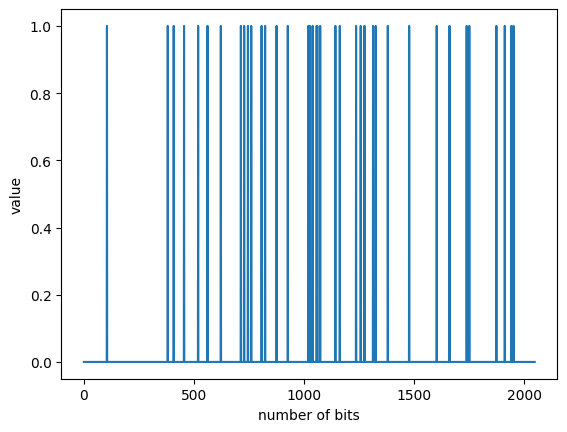

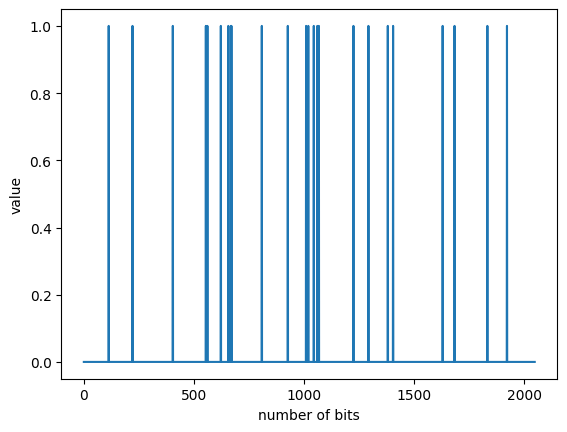

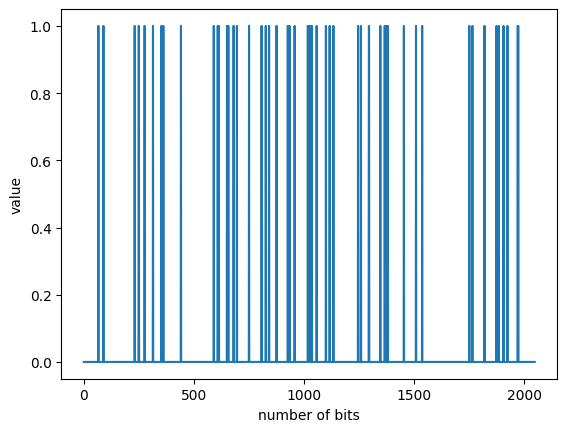

In [44]:
visualize_fingerprint(fingerprints, 2049, 10)

In those above figures, fingerprint[2] aand fingerprint[9] could be used to demonstrate when the Eucledian distance gets  larger, compared to the distance between fingerprint[2] aand fingerprint[4] 

In [45]:
# compute Eucledian distance
dist1 = np.linalg.norm(fingerprints[2] - fingerprints[4])
dist2 = np.linalg.norm(fingerprints[2] - fingerprints[9])
 
# printing Euclidean distance
print(f' Eucledian distance between 2 and 4: {dist1}')
print(f' Eucledian distance between 2 and 9: {dist2}')

 Eucledian distance between 2 and 4: 5.385164807134504
 Eucledian distance between 2 and 9: 8.18535277187245


This could only conclude the structural difference but not the solubility of each molecules, as they also depend on other hydrophilic groups. 

In [46]:
from sklearn.manifold import TSNE
tsne_results = TSNE(n_components=2).fit_transform(fingerprints)

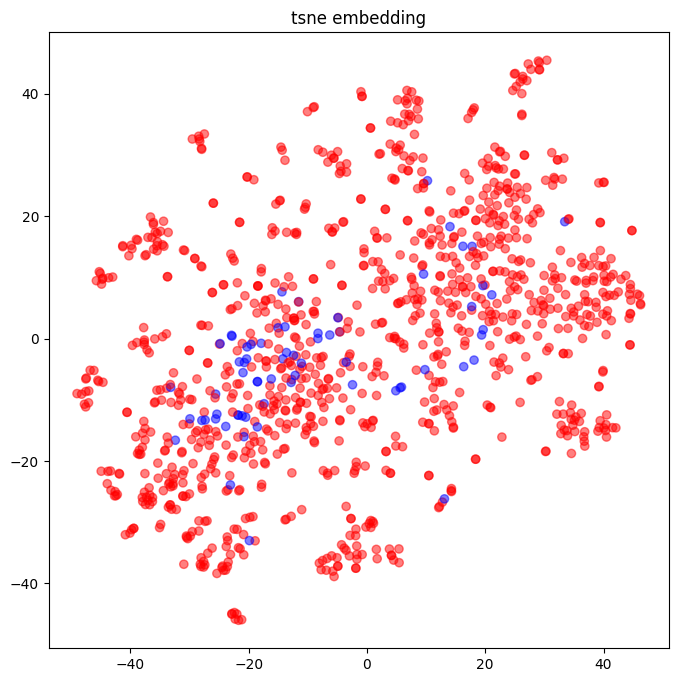

In [47]:
import seaborn as sns
tsne_results = TSNE(n_components=2).fit_transform(fingerprints)
tsne_df = pd.DataFrame()
tsne_df["dim_0"], tsne_df["dim_1"] = tsne_results[:,0],tsne_results[:,1]
tsne_df["labels"] = cat_labels
tsne_df["labels"] = tsne_df["labels"].astype(str)

tsne_colors={"0":"red","1":"blue"}
plt.figure(figsize=(8,8))
plt.scatter(x= tsne_df["dim_0"],y= tsne_df["dim_1"],
            c=tsne_df["labels"].map(tsne_colors),
            alpha=0.5)
              
plt.title("tsne embedding")
plt.show()


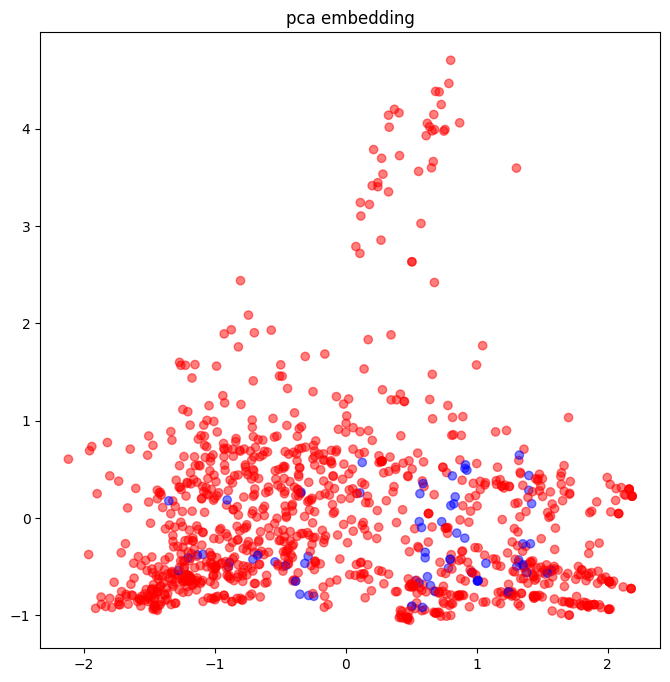

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_clusters = pca.fit_transform(fingerprints)

pca_df = pd.DataFrame()
pca_df["dim_0"], pca_df["dim_1"] = pca_clusters[:,0], pca_clusters[:,1]
pca_df["labels"] = cat_labels
pca_df["labels"] = pca_df["labels"].astype(str)

pca_colors = {"0":"red","1":"blue"}
plt.figure(figsize=(8,8))
plt.scatter(x= pca_df["dim_0"],y= pca_df["dim_1"],c=pca_df["labels"].map(pca_colors), alpha=0.5)
              
plt.title("pca embedding")
plt.show()

From the Visualization of T-SNE and PCA, I think TSNE could separate two groups better that PCA. From my understanding, this could be due to the fact that T-SNE is a manifold learning method whereas PCA is a matrix factorization method. Thus TSNE could be more appropriate to study graph structures such as molecules.

Since T-SNE has better performance, I repeat another experiment with n_components=3 in order to see if those clusters are better separated. 

In the following experiment, I will demonstrate another clustering technique called UMAP, which stands for Unified Manifold Approximation and Projection. It has been introduced in 2018 and other reports say that it has better performance compared to T-SNE.

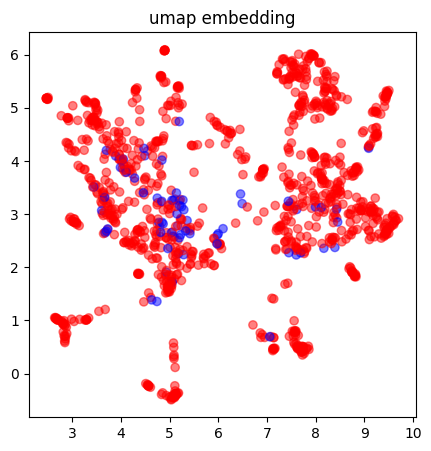

In [49]:
import umap

umap_model = umap.UMAP(n_neighbors=25,min_dist=0.001, n_components=2, random_state=0)
umap_outputs = umap_model.fit_transform(fingerprints)

umap_df = pd.DataFrame()

umap_df["dim_0"], umap_df["dim_1"] =  umap_outputs[:,0], umap_outputs[:,1]
umap_df["labels"] = cat_labels
umap_df["labels"] =umap_df["labels"].astype(str)

colors={"0":"red","1":"blue"}

plt.figure(figsize=(5,5))
plt.scatter(x= umap_df["dim_0"],
            y= umap_df["dim_1"],
            c=umap_df["labels"].map(colors),
            alpha=0.5)
              
plt.title("umap embedding")
plt.show()

# Interactive visualization

In [50]:

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

Loading BokehJS ...

In [51]:
p = figure()
p.circle(x= umap_df["dim_0"],y= umap_df["dim_1"], fill_alpha=0.6, line_color=None)
show(p)

In [52]:
import pandas as pd
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3
bpl.output_notebook()


source = bpl.ColumnDataSource(umap_df)

# use whatever palette you want...
palette = ["pink","blue"]
color_map = bmo.CategoricalColorMapper(factors=["0","1"],
                                   palette=palette)

# create figure and plot
p = bpl.figure()
p.scatter(x='dim_0', y='dim_1',
          color={'field': 'labels', 'transform': color_map},
          source=source)
bpl.show(p)

Loading BokehJS ...

In [53]:
'''
    In this part I created a 2D scatter plot of T-SNE outputs to compare
    with the outputs of UMAP.
'''
#re
tsne_results = TSNE(n_components=2, learning_rate="auto").fit_transform(fingerprints)
tsne_df = pd.DataFrame()
tsne_df["dim_0"], tsne_df["dim_1"] = tsne_results[:,0],tsne_results[:,1]
tsne_df["labels"] = cat_labels
tsne_df["labels"] = tsne_df["labels"].astype(str)

source = bpl.ColumnDataSource(tsne_df)

# use whatever palette you want...
palette = ["pink","blue"]
color_map = bmo.CategoricalColorMapper(factors=["0","1"],
                                   palette=palette)

# create figure and plot
p = bpl.figure()
p.scatter(x='dim_0', y='dim_1',
          color={'field': 'labels', 'transform': color_map}, source=source)
bpl.show(p)

In [54]:
def mol2png(mol_list: List[object], mol_name: List[str]):
    for i in range(len(mol_name)):
        fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        temp_mol = mol_list[i]
        im = Chem.Draw.MolToImage(temp_mol)
        ax.imshow(im)
        
        name = mol_name[i].replace("/"," per ")
        
        fig.savefig("images/"+ name +'.png')   # save the figure to file
        plt.close(fig)
        
mol2png(rdkit_mols, compound_id)  

In [55]:
compound_name = [item.replace("/"," per ") for item in compound_id]

In [56]:
img_paths = [ "images/"+ x +'.png' for x in compound_name]

output_file("interactive_plot.html")

source = ColumnDataSource(
        data=dict(
            x=umap_df["dim_0"],
            y=umap_df["dim_1"],
            labels = umap_df["labels"],
            desc = compound_name.copy(),
            imgs = img_paths.copy()
            
        )
    )

hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="200" alt="@imgs" width="200"
                    style="float: left; margin: 10px 10px 10px 10px;"
                    border="0"
                ></img>
            </div>
            <div>
                <span style="font-size: 14px; font-weight: bold;">@desc</span>
            </div>
        </div>
        """
    )
color_map = bmo.CategoricalColorMapper(factors=["0","1"],
                                   palette=palette)

p = figure(plot_width=600, plot_height=600, tools=[hover],title="Interactive plot")

p.legend.location = "top_left"

p.scatter('x', 'y', size=5, source=source,
         color={'field': 'labels', 'transform': color_map},
          legend="labels",
        )

show(p)

Some of my observations:
- the number of molecules in class 1 (blue and LogS > 0) is more located on the left cluster. it look like they are small molecule alkane, alkenes (< 5 C molecules) or single benzene with -OH alcohol groups. 
- The large molecules with multiple rings are clustered on the right-hand group. Among these The soluble ones (blue points) often have -OH group (alcohol) or -N= amine. 
- Most of soluble molecules has one -OH and/or =O aldehyde and/or amine -N= group. This means that they are more polar, which helps them easier to dissolve in water or other polar solvents, for example alcohols. The general rule is "like dissolves like".
- In contrast, other molecules such as large alkanes or alkenes are non-polar is more likely insoluble. Those are more likely to be found on the top-left quadrant.  

In [58]:
import dash
from dash import dcc
from dash import html
import plotly.graph_objs as go

In [59]:
app = dash.Dash()

#create 3d scatter plot of UMAP
umap_3d_model = umap.UMAP(n_neighbors=25,min_dist=0.001, n_components=3, random_state=0)
umap_3d_outputs = umap_3d_model.fit_transform(fingerprints)

umap_3d_df = pd.DataFrame()

umap_3d_df["dim_0"], umap_3d_df["dim_1"], umap_3d_df["dim_2"] =  umap_3d_outputs[:,0], umap_3d_outputs[:,1], umap_3d_outputs[:,2]
umap_3d_df["labels"] = cat_labels
umap_3d_df["labels"] =umap_3d_df["labels"].astype(str)


#create 3d scatter plot of TSNE
tsne_model = TSNE(n_components=3, learning_rate="auto")
tsne_3d_outputs = tsne_model.fit_transform(fingerprints)

tsne_3d_df = pd.DataFrame()
tsne_3d_df["dim_0"], tsne_3d_df["dim_1"], tsne_3d_df["dim_2"] = tsne_3d_outputs[:,0],tsne_3d_outputs[:,1],tsne_3d_outputs[:,2] 
tsne_3d_df["labels"] = cat_labels
tsne_3d_df["labels"] = tsne_3d_df["labels"].astype(str)

In [60]:
app.layout = html.Div([
    #create 3D visualization of UMAP models
    dcc.Graph(
        id="umap_scatter_plot",
        figure= {
            "data" : [
                go.Scatter3d(
                    x=umap_3d_df["dim_0"],
                    y=umap_3d_df["dim_1"],
                    z=umap_3d_df["dim_2"],
                    mode="markers",
                    marker= dict(
                        size=8,
                        color=umap_3d_df["labels"].map({"0":"red","1":"blue"}),
                        opacity=0.8
                    ),
                    text = compound_name.copy(),
                    hovertemplate='<b>%{text}</b><extra></extra>'
                ),
            ],
            "layout" : go.Layout(
                title = "UMAP Scatter Plot",
                xaxis = {"title" : "dim_0"},
                yaxis = {"title" : "dim_1"},
                
            )
        }
    ),
    
    #create 3D visualization of TSNE models
    dcc.Graph(
        id="tsne_scatter_plot",
        figure= {
            "data" : [
                go.Scatter3d(
                    x=tsne_3d_df["dim_0"],
                    y=tsne_3d_df["dim_1"],
                    z=tsne_3d_df["dim_2"],
                    mode="markers",
                    marker= dict(
                        size=8,
                        color=tsne_3d_df["labels"].map({"0":"red","1":"blue"}),
                        opacity=0.8
                    ),
                    text = compound_name.copy(),
                    hovertemplate='<b>%{text}</b><extra></extra>'
                ),
            ],
            "layout" : go.Layout(
                title = "TSNE Scatter Plot",
                xaxis = {"title" : "dim_0"},
                yaxis = {"title" : "dim_1"},
            
            )
        }
    )
    
])

In [61]:
if __name__ == "__main__": 
    app.run_server(port=5366)

Dash is running on http://127.0.0.1:5366/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5366
Press CTRL+C to quit
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suites/dash/deps/react@16.v2_6_2m1663979822.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_6_2m1663979822.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_6_2m1663979822.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_6_2m1663979822.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suites/dash/dcc/dash_core_components-shared.v2_6_2m1663979821.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_6_2m1663979821.min.js HTTP/1.1" 200 -
127.0.0.1 - - [27/Oct/2022 11:13:37] "GET /_dash-component-suit

In this experiment, the 3D scatter plot of UMAP shows a better separation compare to the TSNE. It is consistent with my findings in 2D scatter plot. 